In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/monkeypox-skin-lesion-dataset/Monkeypox_Dataset_metadata.csv
/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Val/Monkeypox/M34_02_07.jpg
/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Val/Monkeypox/M53_01_02.jpg
/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Val/Monkeypox/M50_03_04.jpg
/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Val/Monkeypox/M34_04_07.jpg
/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Val/Monkeypox/M34_01_09.jpg
/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Val/Monkeypox/M34_03_13.jpg
/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Val/Monkeypox/M17_02_10.jpg
/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Val/Monkeypox/M50_03_06.jpg
/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Val/Monkeypox/M17_01_13.jpg
/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Val/Monkeypox/M34_02_10.jpg
/kaggle/input/monkeypox-s

In [2]:
import tensorflow as tf
import os
import numpy as np
import cv2
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import VGG19
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Flatten, Dense, Dropout, LeakyReLU
import warnings
warnings.filterwarnings('ignore')

In [3]:
def load_and_preprocess_images(folder_path, subfolders, image_size=(224, 224)):
    
    label_map = {subfolder: idx for idx, subfolder in enumerate(subfolders)}
    
    images = []
    labels = []
    
    for subfolder in subfolders:
        subfolder_path = os.path.join(folder_path, subfolder)
        for filename in os.listdir(subfolder_path):
            img_path = os.path.join(subfolder_path, filename)
            img = cv2.imread(img_path)
            if img is not None:
                
                img_resized = cv2.resize(img, image_size)
                images.append(img_resized)
                labels.append(label_map[subfolder])
    
    images = np.array(images)
    labels = np.array(labels)
    
    images = images.astype('float32') / 255.0
    
    return images, labels

In [4]:
folder_path ="/kaggle/input/monkeypox-skin-lesion-dataset/Augmented Images/Augmented Images"
subfolders = ['Monkeypox_augmented','Others_augmented']

In [5]:
images, labels = load_and_preprocess_images(folder_path, subfolders)

In [6]:
# One-hot encode the labels to match the model output
labels_one_hot = tf.keras.utils.to_categorical(labels, num_classes=2) #used for encoding(string to binary(0 & 1))

In [7]:
# Initialize 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
acc_per_fold = []
loss_per_fold = []

In [8]:
# Start 10-fold cross-validation
for train_index, test_index in kf.split(images):
    train_images, test_images = images[train_index], images[test_index]
    train_labels, test_labels = labels_one_hot[train_index], labels_one_hot[test_index]
    
    # Split further into train and validation sets
    train_images, val_images, train_labels, val_labels = train_test_split(
        train_images, train_labels, test_size=0.1, random_state=42, stratify=train_labels.argmax(axis=1)
    )
    
    # Prepare data for training
    train_data = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(len(train_labels)).batch(32)
    val_data = tf.data.Dataset.from_tensor_slices((val_images, val_labels)).batch(32)

  

    base_model = VGG19(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3))
    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(1024,activation='relu'))
  
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))


    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])

    # Train the model for this fold
    print(f"Training fold {fold_no} ...")
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=30,
        verbose=1
    )

    # Evaluate the model on the test set for this fold
    results = model.evaluate(test_images, test_labels, verbose=0)
    test_loss, test_accuracy, precision, recall = results
    
    # Calculate F1 Score
    f1_score = 2 * (precision * recall) / (precision + recall)
    
    # Save results
    acc_per_fold.append(test_accuracy)
    loss_per_fold.append(test_loss)
    
    print(f"Fold {fold_no} - Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy * 100:.2f}%")
    print(f"Precision: {precision * 100:.2f}% - Recall: {recall * 100:.2f}% - F1 Score: {f1_score * 100:.2f}%")
    
    fold_no += 1

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training fold 1 ...
Epoch 1/30


I0000 00:00:1738312795.209258     100 service.cc:145] XLA service 0x7d1490003020 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738312795.209319     100 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1738312816.352837     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


72/72 ━━━━━━━━━━━━━━━━━━━━ 62s 491ms/step - accuracy: 0.6351 - loss: 0.6537 - precision: 0.6351 - recall: 0.6351 - val_accuracy: 0.7617 - val_loss: 0.5333 - val_precision: 0.7617 - val_recall: 0.7617
Epoch 2/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 252ms/step - accuracy: 0.7529 - loss: 0.5240 - precision: 0.7529 - recall: 0.7529 - val_accuracy: 0.8633 - val_loss: 0.4039 - val_precision: 0.8633 - val_recall: 0.8633
Epoch 3/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 252ms/step - accuracy: 0.8027 - loss: 0.4584 - precision: 0.8027 - recall: 0.8027 - val_accuracy: 0.9023 - val_loss: 0.2797 - val_precision: 0.9023 - val_recall: 0.9023
Epoch 4/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 253ms/step - accuracy: 0.8957 - loss: 0.2931 - precision: 0.8957 - recall: 0.8957 - val_accuracy: 0.8945 - val_loss: 0.2928 - val_precision: 0.8945 - val_recall: 0.8945
Epoch 5/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 252ms/step - accuracy: 0.9020 - loss: 0.2697 - precision: 0.9020 - recall: 0.9020 - val_accuracy: 0.9219 - val_loss: 0.1780 -

In [10]:
# Calculate average metrics across all folds
print(f"\nAverage Accuracy: {np.mean(acc_per_fold) * 100:.2f}%")
print(f"Average Loss: {np.mean(loss_per_fold):.4f}")
print("Training complete across all folds.")


Average Accuracy: 86.08%
Average Loss: 0.3267
Training complete across all folds.


In [11]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 512)            │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │         2,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,655,240 (235.20 MB)

 Trainable params: 20,551,746 (78.40 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 41,103,494 (156.80 MB)

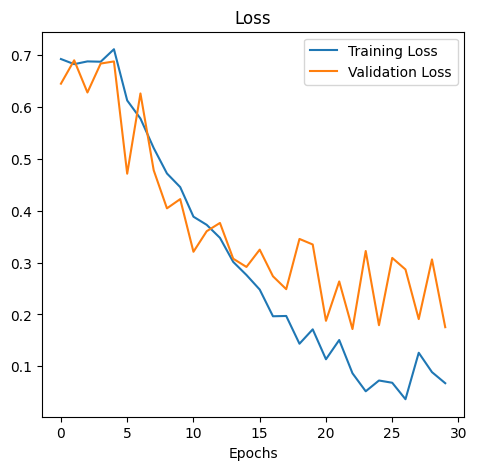

In [12]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(len(loss))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()


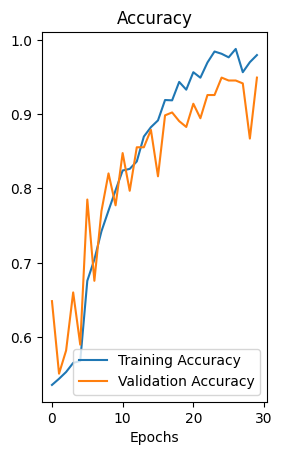

In [13]:
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend()

plt.show()

In [14]:
preds = model.predict(test_images)
predicted_classes = np.argmax(preds, axis=1)

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step


In [15]:
import numpy as np
test_labels_single = np.argmax(test_labels, axis=1)  # Convert to single label format

In [17]:
print("Shape of test_labels:", test_labels.shape)
print("Shape of predicted_classes:", predicted_classes.shape)


Shape of test_labels: (638, 2)
Shape of predicted_classes: (638,)


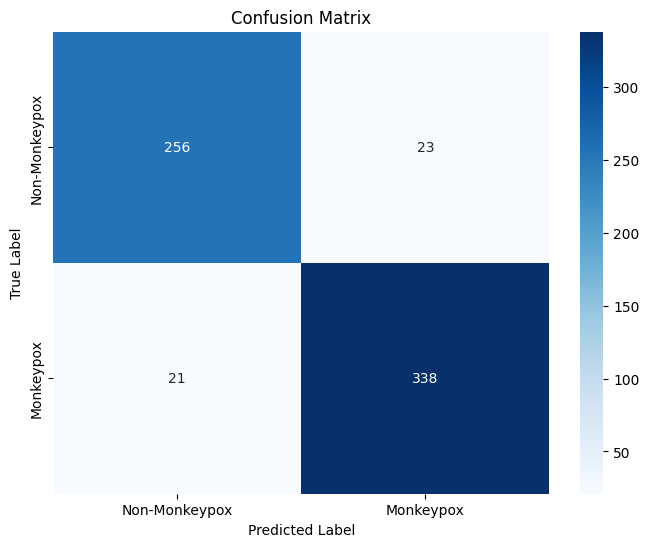

In [18]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Convert one-hot encoded labels (if needed)
test_labels_single = np.argmax(test_labels, axis=1)  # If test_labels are one-hot encoded
# predicted_classes_single = np.argmax(predicted_classes, axis=1)  # If predicted_classes are one-hot encoded

# Compute the confusion matrix
cm = confusion_matrix(test_labels_single, predicted_classes)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Monkeypox', 'Monkeypox'], yticklabels=['Non-Monkeypox', 'Monkeypox'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
